In [28]:
import os
import sys
import import_ipynb

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms

from model import MonodepthModel
from ipynb.fs.full.utils import scale_pyramid

In [29]:
class KITTIDataset(Dataset):
    def __init__(self):
        self.rootdir = "/home/sur/MonoDepth1_Implementation/dataset/testing"
        self.left_images = []
        self.ground_truth_disparity_images = []
        self.height = 512
        self.length = 256
        self.total_left_images = 0
        self.total_ground_truth_disparity_images = 0
        for subdir, dirs, files in os.walk(self.rootdir):
            if "image_2" in subdir: #Left RGB Folder
                for file in files:
                    if "_10.png" in file:
                        left_file = os.path.join(subdir, file)
                        self.left_images.append(left_file)
                        self.total_left_images += 1
                
            if "disp_noc_0" in subdir: # GT disparity folder
                for file in files:
                    if ".png" in file:
                        gt_file = os.path.join(subdir, file)
                        self.ground_truth_disparity_images.append(gt_file)
                        self.total_ground_truth_disparity_images += 1
        
        self.left_images.sort()
        self.ground_truth_disparity_images.sort()
        assert len(self.left_images) == len(self.ground_truth_disparity_images)
        print("Total Stereo images acquired: ", self.total_left_images)       

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, idx):
        left_img = cv2.imread(self.left_images[idx])
        ground_truth_disp = cv2.imread(self.ground_truth_disparity_images[idx],cv2.IMREAD_GRAYSCALE)

        np.asarray(left_img)
        np.asarray(ground_truth_disp)
        
        left_img = cv2.resize(left_img,(self.height, self.length))

        left_img = np.moveaxis(left_img, 2,0)

        return {"left_img":left_img,"ground_truth_disp":ground_truth_disp}

"""
For Result Comparison
Return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3
"""
def compute_errors(ground_truth_depth, predicted_depth):
    thresh = np.maximum((ground_truth_depth / predicted_depth), (predicted_depth / ground_truth_depth))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (ground_truth_depth - predicted_depth) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(ground_truth_depth) - np.log(predicted_depth)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(ground_truth_depth - predicted_depth) / ground_truth_depth)

    sq_rel = np.mean(((ground_truth_depth - predicted_depth)**2) / ground_truth_depth)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

"""
depth = (baselength * focal length) / disparity

            
            gt_disparities.append(image_left) #size (3, 256, 512)
            pred_disparities.append(resized_right_disp) #size (375, 1242)
"""
def convert_disps_to_depths_kitti(ground_truth_disparities, predicted_disparities):
    gt_depths = []
    pred_depths = []
    width_to_focal = dict()
    width_to_focal[1242] = 721.5377
    width_to_focal[1241] = 718.856
    width_to_focal[1224] = 707.0493
    width_to_focal[1238] = 718.3351

    
    for i in range(len(ground_truth_disparities)):
        gt_disp = ground_truth_disparities[i]
        height, width = gt_disp.shape
        pred_disp = predicted_disparities[i]

        gt_mask = gt_disp > 0
        pred_mask = pred_disp > 0

        gt_depth = width_to_focal[width] * 0.54 / (gt_disp + (1.0 - gt_mask))
        pred_depth = width_to_focal[width] * 0.54 / (pred_disp + (1.0 - pred_mask))

        gt_depths.append(gt_depth)
        pred_depths.append(pred_depth)
    return gt_depths, pred_depths



Total Stereo images acquired:  200
gt_depth max:  389.630358    gt_depth min:  6.08797434375
pred_depth max:  5188991147.717122    pred_depth min:  389.6303591793325
gt_depth max:  389.630358    gt_depth min:  4.995261
pred_depth max:  1781213033.6761808    pred_depth min:  389.6303701788767
gt_depth max:  389.630358    gt_depth min:  5.9034902727272724
pred_depth max:  581850457.3082218    pred_depth min:  389.6303640327396


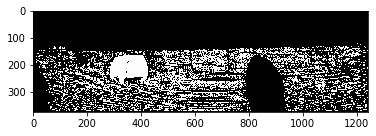

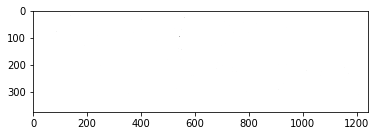

gt_depth max:  389.630358    gt_depth min:  3.8199054705882354
pred_depth max:  4591082702.71268    pred_depth min:  389.63042475703656
gt_depth max:  389.630358    gt_depth min:  3.9758199795918365
pred_depth max:  1509737486.4516692    pred_depth min:  389.63053914102517
gt_depth max:  389.630358    gt_depth min:  3.857726316831683
pred_depth max:  23673911867.568832    pred_depth min:  389.6304192799423
gt_depth max:  389.630358    gt_depth min:  3.388090069565217
pred_depth max:  15494904121.655296    pred_depth min:  389.6304396574552
gt_depth max:  389.630358    gt_depth min:  5.6468167826086955
pred_depth max:  4569145788.774804    pred_depth min:  389.63036016588956
gt_depth max:  389.630358    gt_depth min:  5.6468167826086955
pred_depth max:  2955319461.613725    pred_depth min:  389.6303690534079
gt_depth max:  389.630358    gt_depth min:  5.6468167826086955
pred_depth max:  3323633853.304413    pred_depth min:  389.6304229993769
gt_depth max:  389.630358    gt_depth min:  5

gt_depth max:  389.630358    gt_depth min:  3.24691965
pred_depth max:  5861469860.380988    pred_depth min:  389.63037907490025
gt_depth max:  389.630358    gt_depth min:  5.9943132
pred_depth max:  21593987053.55742    pred_depth min:  389.63035886181996
gt_depth max:  389.630358    gt_depth min:  5.729858205882353
pred_depth max:  939612377.9555149    pred_depth min:  389.6303750549635
gt_depth max:  389.630358    gt_depth min:  4.478509862068965
pred_depth max:  2975682854.2143087    pred_depth min:  389.6303845123043
gt_depth max:  389.630358    gt_depth min:  5.9943132
pred_depth max:  2072383461.4721634    pred_depth min:  389.63036115386404
gt_depth max:  389.630358    gt_depth min:  1.7710470818181818
pred_depth max:  3268456338.161664    pred_depth min:  389.6304170148294
gt_depth max:  389.630358    gt_depth min:  6.08797434375
pred_depth max:  2245864311.5433946    pred_depth min:  389.63049056155756
gt_depth max:  389.630358    gt_depth min:  5.6468167826086955
pred_depth 

gt_depth max:  389.630358    gt_depth min:  6.184608857142857
pred_depth max:  3556747386.0547757    pred_depth min:  389.6304010002832
gt_depth max:  389.630358    gt_depth min:  5.6468167826086955
pred_depth max:  2696937381.3678837    pred_depth min:  389.63037269629825
gt_depth max:  389.630358    gt_depth min:  4.870379475
pred_depth max:  681372005.3496629    pred_depth min:  389.63038956982723
gt_depth max:  389.630358    gt_depth min:  4.638456642857143
pred_depth max:  5468789689.995987    pred_depth min:  389.6304250745493
gt_depth max:  389.630358    gt_depth min:  5.265275108108108
pred_depth max:  9667880239.11188    pred_depth min:  389.6304088700618
gt_depth max:  389.630358    gt_depth min:  5.265275108108108
pred_depth max:  1992498461.2457473    pred_depth min:  389.63043868223747
gt_depth max:  389.630358    gt_depth min:  5.126715236842105
pred_depth max:  2162079644.8821344    pred_depth min:  389.63036332400605
gt_depth max:  389.630358    gt_depth min:  5.9034902

In [30]:
if __name__ == '__main__':    
    # load dataset 
    dataset = KITTIDataset()
    TestLoader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False, num_workers = 0)
    # load model
    net = MonodepthModel()
    net.to(torch.device("cuda:0")) 
    net.load_state_dict(torch.load("/home/sur/MonoDepth1_Implementation/monodepth_weight.pth"))
    is_gpu_available = torch.cuda.is_available()
    
    left_image = []
    gt_disparities = []
    pred_right_disp = []
    for batch, sample_batched in enumerate(TestLoader):
        with torch.no_grad():    
            left_original = sample_batched["left_img"]
            gt_original = sample_batched["ground_truth_disp"]

            if is_gpu_available: 
                left = left_original.type(torch.FloatTensor).cuda()
            else:
                left = left_original.type(torch.FloatTensor)

            left_pyramid = scale_pyramid(left,4)

            # Forward pass
            output = net.forward(left)

            # Output from the network 2*4 disparity maps from 4 diff levels 
            left_disp = [output[i][:, 0, :, :] for i in range(4)]
            right_disp = [output[i][:, 1, :, :] for i in range(4)]
            
            pred_right_disp_1 = cv2.resize(right_disp[0][0].detach().cpu().numpy(),(gt_original[0].shape[1], gt_original[0].shape[0]))
            left_image_1 = cv2.resize(np.transpose(left_original[0].detach().cpu().numpy(), (1, 2, 0)),(gt_original[0].shape[1], gt_original[0].shape[0]))
            gt_disparities_1 = gt_original[0].detach().cpu().numpy()
            
            left_image.append(left_image_1)
            gt_disparities.append(gt_disparities_1)
            pred_right_disp.append(pred_right_disp_1)
            
            """
            print("pred_right_disp: ", pred_right_disp_1.shape)
            print("left_image: ", left_image_1.shape)
            print("gt_disparities: ", gt_disparities_1.shape)
            plt.imshow(pred_right_disp_1, cmap = "plasma")
            plt.show()          
            plt.imshow(left_image_1, cmap = "plasma")
            plt.show()
            plt.imshow(gt_disparities_1, cmap = "plasma")
            plt.show()
            """                                

    gt_depths, pred_depths = convert_disps_to_depths_kitti(gt_disparities, pred_right_disp)
    num_samples = len(gt_disparities)
    rms     = np.zeros(num_samples, np.float32)
    log_rms = np.zeros(num_samples, np.float32)
    abs_rel = np.zeros(num_samples, np.float32)
    sq_rel  = np.zeros(num_samples, np.float32)
    d1_all  = np.zeros(num_samples, np.float32)
    a1      = np.zeros(num_samples, np.float32)
    a2      = np.zeros(num_samples, np.float32)
    a3      = np.zeros(num_samples, np.float32)
    min_depth = 0
    max_depth = 390

    for i in range(num_samples):
        gt_depth = gt_depths[i]
        pred_depth = pred_depths[i]

        pred_depth[pred_depth < min_depth] = min_depth
        pred_depth[pred_depth > max_depth] = max_depth

        gt_disp = gt_disparities[i]
        mask = gt_disp > 0
        pred_disp = pred_right_disp[i]
        
        print("gt_depth max: ",gt_depth.max(),"   gt_depth min: ",gt_depth.min())
        print("pred_depth max: ",pred_depth.max(),"   pred_depth min: ",pred_depth.min())

        disp_diff = np.abs(gt_disp[mask] - pred_disp[mask])
        bad_pixels = np.logical_and(disp_diff >= 3, (disp_diff / gt_disp[mask]) >= 0.05)
        d1_all[i] = 100.0 * bad_pixels.sum() / mask.sum()

        abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth[mask])
        if i == 2 :
            plt.imshow(gt_depth, cmap = "Greys")
            plt.show()          
            plt.imshow(pred_depth, cmap = "Greys")
            plt.show()


    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'd1_all', 'a1', 'a2', 'a3'))
    print("{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), d1_all.mean(), a1.mean(), a2.mean(), a3.mean()))
    


In [31]:
print(pred_right_disp[2][10:20, 10:15])
print(gt_disparities[2][10:20, 10:15])
print(pred_depths[2][10:20, 10:15])
print(gt_depths[2][10:20, 10:15])

[[0.02739792 0.03206586 0.02824642 0.0242077  0.01900227]
 [0.01405784 0.01959226 0.01927619 0.01849574 0.01524432]
 [0.00488246 0.01254386 0.01635833 0.01903289 0.01564203]
 [0.00821147 0.01730871 0.02564253 0.03190136 0.02711914]
 [0.00609824 0.01361192 0.02180833 0.02798586 0.02342088]
 [0.00137265 0.00561167 0.01058037 0.01437246 0.01190385]
 [0.00599657 0.01036084 0.0137806  0.01745804 0.02250663]
 [0.01036047 0.01474852 0.01679238 0.01970806 0.02726264]
 [0.01395626 0.01839091 0.01940421 0.02135322 0.02828111]
 [0.01485367 0.01966191 0.02073089 0.02229936 0.02652564]]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[ 14221.1668756   12150.93877005  13793.97517365  16095.30923024
   20504.41326989]
 [ 27716.22260754  19886.95225917  20213.033364    21065.94875301
   25559.04506669]
 [ 79802.05086897  31061.4313022   23818.47209246  20471.42586333
   24909.19362129]
 [ 47449.5407829   22510.65485013